In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

,gene_id,description,gene_type,locus,RNA1_FPKM,RNA102_FPKM,RNA104_FPKM,RNA108_FPKM,RNA109_FPKM,RNA110_FPKM,...,R_JS032_count,R_JS033_count,R_JS034_count,R_JS035_count,R_JS036_count,R_JS037_count,R_JS038_count,R_JS039_count,R_JS040_count,R_JS041_count
gene_name,,,,,,,,,,,,,,,,,,,,,
AC073488.4,ENSG00000282222,"chromodomain protein, Y chromosome-like (CDYL)...",processed_pseudogene,X:9410789-9411545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
AC119427.1,ENSG00000282221,"novel transcript, antisense to LAD1",lncRNA,1:201399633-201401190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
MIR543,ENSG00000212040,microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664],miRNA,14:101031987-101032064,0.000000,0.000000,0.000000,0.000000,0.000000,0.962816,...,0,0,0,0,0,0,0,0,0,0
MADD,ENSG00000110514,MAP kinase activating death domain [Source:HGN...,protein_coding,11:47269161-47330031,6.345943,8.482109,10.209322,7.143557,5.671481,7.776351,...,1187,1254,1767,1184,2418,1294,1254,1461,1323,1795
AL356737.2,ENSG00000287159,"novel transcript, antisense to GPC5",lncRNA,13:92610646-92677725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

In [5]:
df.shape

(60675, 390)

### Transform the Dataset

In [6]:
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset21/data0.csv')

In [7]:
df

gene_name,AC073488.4,AC119427.1,MIR543,MADD,AL356737.2,MAST2,TRBJ2-5,TRBJ2-4,SAA2-SAA4,TRBJ2-3,...,AC092437.1,AC131212.4,Z83836.1,RBM10,PRKCZ-AS1,GALNT9,GABPB2,PLBD1-AS1,RNU6-1090P,AL023882.1
gene_type,processed_pseudogene,lncRNA,miRNA,protein_coding,lncRNA,protein_coding,TR_J_gene,TR_J_gene,protein_coding,TR_J_gene,...,TEC,TEC,TEC,protein_coding,lncRNA,protein_coding,protein_coding,lncRNA,snRNA,lncRNA
RNA1_FPKM,0.0,0.0,0.0,6.345943,0.0,0.86931,6.62019,14.29961,0.0,27.561607,...,0.303215,0.081479,0.0,18.065813,2.203156,0.0,3.027988,0.676363,0.0,0.043794
RNA102_FPKM,0.0,0.0,0.0,8.482109,0.0,1.497604,1.569853,1.507059,0.0,9.228358,...,0.0,0.0,0.0,17.878264,1.969454,0.01469,2.766359,1.150103,0.0,0.623174
RNA104_FPKM,0.0,0.0,0.0,10.209322,0.0,1.885831,3.085139,7.402744,0.0,16.61873,...,0.0,0.0,0.0,16.252944,1.263376,0.028862,2.665226,1.141618,0.0,0.571317
RNA108_FPKM,0.0,0.0,0.0,7.143557,0.0,1.245977,3.351034,8.041719,0.0,14.769571,...,0.0,0.0,0.0,15.934811,2.444487,0.0,2.187239,2.350972,0.0,0.398958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R_JS037_FPKM,0.0,0.0,0.0,8.396802,0.0,1.157648,3.773474,14.492225,0.0,14.787984,...,0.0,0.0,0.0,13.580158,2.366973,0.026488,4.2895,1.091251,0.0,0.499304
R_JS038_FPKM,0.1133,0.0,0.0,7.705327,0.0,1.141251,1.786837,13.722905,0.0,29.756299,...,0.0,0.263902,0.0,13.289845,2.607308,0.0,2.415953,0.716444,0.0,0.614656
R_JS039_FPKM,0.0,0.0,0.0,8.115721,0.0,1.221781,1.615103,7.754087,0.0,23.735377,...,0.0,0.079513,0.0,15.41571,2.439791,0.007557,3.050911,0.685049,0.0,0.598406
R_JS040_FPKM,0.0,0.0,0.0,7.630287,0.0,0.873866,8.385021,19.320696,0.0,27.928893,...,0.460856,0.0,0.049023,15.004002,3.348856,0.023539,2.756612,0.491421,0.0,0.798794


### Combine with Diagnosis

In [15]:
df = pd.read_csv('../Datasets/Dataset21/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset21/data1.csv')

df.head()

,TRAV18,TRAV1-2,TRBV14,TRBV17,TRBV5-1,TRBV5-7,TRBV10-3,TRBV15,TRBV6-2,TRBV7-4,...,TRBV16,TRBV12-3,TRBV30,TRBV25-1,TRBV12-5,TRBV7-2,TRAV40,TRAV39,TRBV11-3,Diagnosis
RNA1_FPKM,0.000000,1.383323,0.0,0.0,3.167944,0.0,4.749267,1.509592,1.311547,0.457881,...,1.144701,10.100042,5.331696,2.710629,0.000000,2.822822,0.000000,3.120089,1.215953,1
RNA102_FPKM,0.000000,4.686665,0.0,0.0,1.502656,0.0,3.686132,1.253070,0.000000,1.085984,...,0.000000,6.448999,1.517334,0.000000,2.016920,0.956438,0.000000,0.910609,2.114679,2
RNA104_FPKM,0.504660,0.920739,0.0,0.0,2.384344,0.0,3.419616,2.110121,1.047596,0.213381,...,0.000000,15.203641,3.974592,1.165828,0.720423,1.503015,0.233575,1.341935,1.322000,1
RNA108_FPKM,0.182697,1.600304,0.0,0.0,0.369994,0.0,1.966600,1.528081,1.517270,0.000000,...,1.853955,10.223482,12.232601,0.633166,0.391362,1.632798,0.000000,0.242860,0.615399,1
RNA109_FPKM,0.545250,4.375941,0.0,0.0,1.716985,0.0,0.869095,1.519558,0.565826,0.230538,...,0.000000,9.188867,6.261042,0.629686,0.000000,3.450214,0.000000,1.449367,0.000000,0


### Remove Patients who hasn't Diabetic

In [16]:
df = pd.read_csv('../Datasets/Dataset21/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset21/data2.csv")
df.head()

,TRAV18,TRAV1-2,TRBV14,TRBV17,TRBV5-1,TRBV5-7,TRBV10-3,TRBV15,TRBV6-2,TRBV7-4,...,TRBV16,TRBV12-3,TRBV30,TRBV25-1,TRBV12-5,TRBV7-2,TRAV40,TRAV39,TRBV11-3,Diagnosis
RNA1_FPKM,0.000000,1.383323,0.000000,0.0,3.167944,0.0,4.749267,1.509592,1.311547,0.457881,...,1.144701,10.100042,5.331696,2.710629,0.000000,2.822822,0.000000,3.120089,1.215953,0
RNA102_FPKM,0.000000,4.686665,0.000000,0.0,1.502656,0.0,3.686132,1.253070,0.000000,1.085984,...,0.000000,6.448999,1.517334,0.000000,2.016920,0.956438,0.000000,0.910609,2.114679,1
RNA104_FPKM,0.504660,0.920739,0.000000,0.0,2.384344,0.0,3.419616,2.110121,1.047596,0.213381,...,0.000000,15.203641,3.974592,1.165828,0.720423,1.503015,0.233575,1.341935,1.322000,0
RNA108_FPKM,0.182697,1.600304,0.000000,0.0,0.369994,0.0,1.966600,1.528081,1.517270,0.000000,...,1.853955,10.223482,12.232601,0.633166,0.391362,1.632798,0.000000,0.242860,0.615399,0
RNA110_FPKM,0.682879,3.550164,0.555091,0.0,1.728171,0.0,0.000000,1.249012,0.531526,0.000000,...,0.000000,6.978973,5.713497,0.591515,0.182724,2.478426,0.473815,2.723264,0.574916,0


### Analyze the Dataset

In [17]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)
df.describe()

,TRAV18,TRAV1-2,TRBV14,TRBV17,TRBV5-1,TRBV5-7,TRBV10-3,TRBV15,TRBV6-2,TRBV7-4,...,TRBV16,TRBV12-3,TRBV30,TRBV25-1,TRBV12-5,TRBV7-2,TRAV40,TRAV39,TRBV11-3,Diagnosis
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.590541,3.992277,0.358869,0.008034,1.421915,0.049410,2.430822,4.172319,0.975514,0.777292,...,0.569539,9.317714,6.658776,1.185415,0.771887,2.024402,0.258128,1.209131,1.183604,0.468531
std,0.524286,3.475772,0.716588,0.042436,0.928406,0.145254,2.270244,7.656874,1.070757,0.647518,...,2.573802,4.285184,5.131977,1.008307,1.009932,2.158824,0.545519,0.995055,1.504094,0.500763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.391623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.178138,1.744902,0.000000,0.000000,0.753504,0.000000,0.822275,1.693191,0.378464,0.243637,...,0.000000,6.202549,3.712640,0.426178,0.000000,0.957628,0.000000,0.599988,0.301262,0.000000
50%,0.523496,3.166896,0.000000,0.000000,1.226231,0.000000,1.966600,2.556668,0.651169,0.663798,...,0.000000,9.165596,5.737103,0.993849,0.454269,1.505313,0.000000,0.997015,0.808439,0.000000
75%,0.913100,5.061169,0.468707,0.000000,1.834662,0.000000,3.618747,4.239761,1.175181,1.134285,...,0.266170,11.532760,7.912602,1.746254,1.124953,2.524497,0.300020,1.648238,1.414899,1.000000
max,2.236730,22.769689,4.307313,0.249326,6.936883,0.783116,11.252571,83.977173,8.030027,3.188264,...,27.209929,25.078375,45.103870,4.502790,6.085980,20.129582,4.623396,7.004364,11.963757,1.000000


In [18]:
df.dtypes

TRAV18       float64
TRAV1-2      float64
TRBV14       float64
TRBV17       float64
TRBV5-1      float64
              ...   
TRBV7-2      float64
TRAV40       float64
TRAV39       float64
TRBV11-3     float64
Diagnosis      int64
Length: 107, dtype: object

In [19]:
df.isnull().sum()

TRAV18       0
TRAV1-2      0
TRBV14       0
TRBV17       0
TRBV5-1      0
            ..
TRBV7-2      0
TRAV40       0
TRAV39       0
TRBV11-3     0
Diagnosis    0
Length: 107, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [20]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.48+/-0.10
1   Information Gain (Mutual info)            50            0.48+/-0.10
2   Information Gain (Mutual info)           100            0.48+/-0.10
3   Information Gain (Mutual info)           150            0.48+/-0.10
4   Information Gain (Mutual info)           200            0.48+/-0.10
5          Correlation Coefficient            25            0.71+/-0.08
6          Correlation Coefficient            50            0.62+/-0.06
7          Correlation Coefficient           100            0.63+/-0.06
8          Correlation Coefficient           150            0.64+/-0.07
9          Correlation Coefficient           200            0.64+/-0.07
10                      Chi-Square            25            0.66+/-0.09
11                      Chi-Square            50            0.68+/-0.10
12                      Chi-Square           100            0.63

### Check Feature Importance

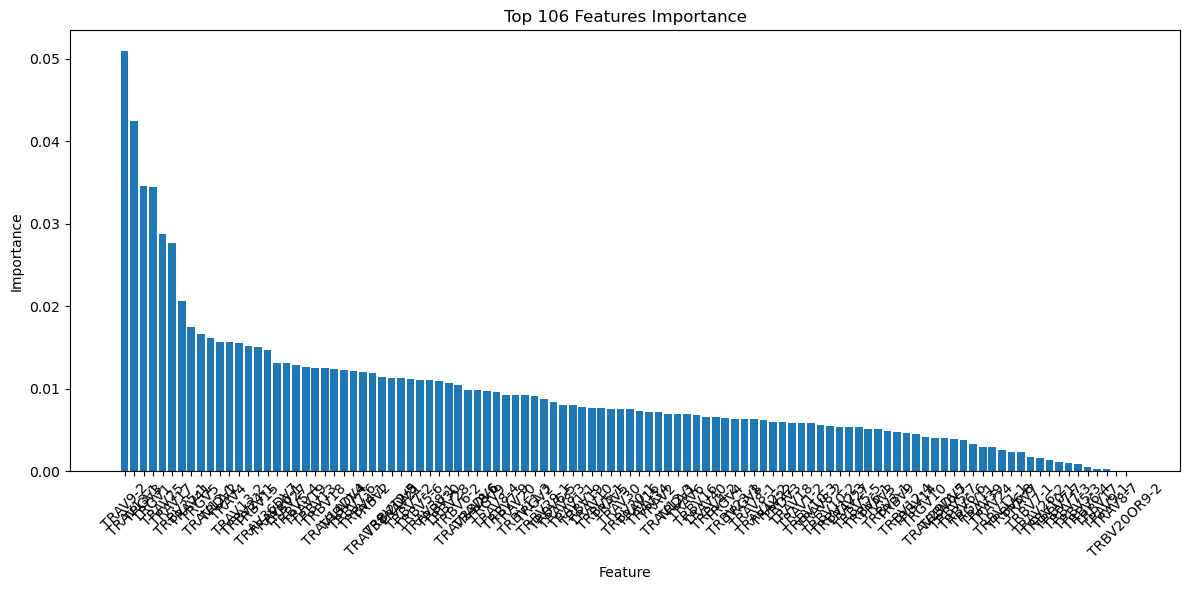

Last important feature:  104


In [21]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [106]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [22]:
df = pd.read_csv("../Datasets/Dataset21/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 104))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset21/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [23]:
feature_counts = list(range(1, 104))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset21/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset21/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 103/103 [03:45<00:00,  2.18s/ feature counts]


In [25]:
df = pd.read_csv("../Datasets/Dataset21/Feature_Select/results.csv")
df.head(10)

,Model Name,Feature Count,CV Score (Mean +/- Std)
0,Random Forest,13,0.8138 +/- 0.0560
1,Random Forest,14,0.8069 +/- 0.0516
2,XGBoost,15,0.8069 +/- 0.0516
3,XGBoost,14,0.8069 +/- 0.0169
4,XGBoost,17,0.8000 +/- 0.0402
5,Random Forest,16,0.7931 +/- 0.0617
6,Random Forest,12,0.7931 +/- 0.0577
7,Random Forest,5,0.7931 +/- 0.0577
8,Random Forest,8,0.7931 +/- 0.0436
9,XGBoost,21,0.7931 +/- 0.0436


### Check Distributions

In [26]:
feature_count = 13

data = pd.read_csv(
    f'../Datasets/Dataset21/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

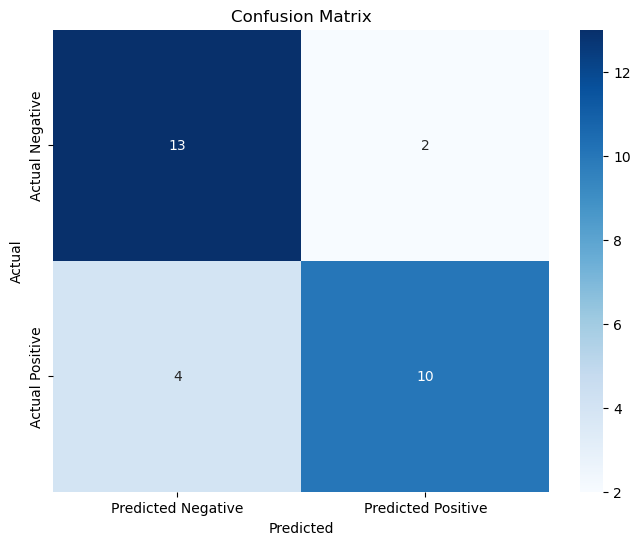

Accuracy: 0.79
Precision: 0.83
Recall (Sensitivity): 0.71
Specificity: 0.87
F1 Score: 0.77


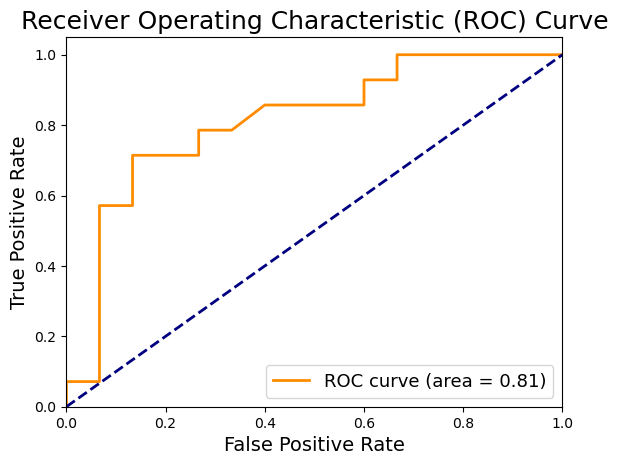

In [30]:
# feature_count = 43

df = pd.read_csv(
    f'../Datasets/Dataset21/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()